In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/oral-cancer-dataset-all-unlabeled'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install dependencies

In [2]:
!pip install torch torchvision matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

# modifying imports and adding glob for file handling

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision.models import densenet121
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import glob

# Checking the dataset name

In [4]:
!ls /kaggle/input/

'all unlabeled'


# Custom dataset for pretraining (unlabeled)

In [5]:
class OralCancerSimCLRDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        print(f"Found {len(self.image_paths)} images in {data_path}")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer (squamous cell carcinoma)
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format (e.g., 'scc' or 'normal').")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img1 = self.transform(img)  # First augmented view
            img2 = self.transform(img)  # Second augmented view
            return img1, img2, label
        return img, img, label

# Custom dataset for downstream classification

In [6]:
class OralCancerDownstreamDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        print(f"Found {len(self.image_paths)} images in {data_path}")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms

In [7]:
transform = T.Compose([
    T.RandomResizedCrop(size=32),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.5),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

downstream_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Oral Cancer dataset for pretraining

In [8]:
data_path = '/kaggle/input/all unlabeled'
if not os.path.exists(data_path):
    raise ValueError(f"Data path {data_path} does not exist. Run '!ls /kaggle/input/' to check.")
print(f"Loading dataset from {data_path}")
train_dataset = OralCancerSimCLRDataset(data_path=data_path, transform=transform)
print(f"Found {len(train_dataset)} images")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

Loading dataset from /kaggle/input/all unlabeled
Found 10002 images in /kaggle/input/all unlabeled
Found 10002 images


In [9]:
for batch in train_loader:
    img1, img2, labels = batch
    print(f"Batch - img1 shape: {img1.shape}, img2 shape: {img2.shape}, labels shape: {labels.shape}")
    break

Batch - img1 shape: torch.Size([64, 3, 32, 32]), img2 shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])


# SimCLR model

In [17]:
class SimCLR(nn.Module): 
    def __init__(self, feature_dim=128): 
        super(SimCLR, self).__init__()

        # Backbone encoder (change to DenseNet121)
        self.f = models.densenet121(weights=None)
        self.f.classifier = nn.Identity()  # Remove the final classifier layer

        # Projection head (MLP) - adjust input dim to 1024
        self.g = nn.Sequential(
            nn.Linear(1024, 512, bias=False),  
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True)
        )

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return torch.nn.functional.normalize(out, dim=-1)
    
    @property
    def encoder(self):
        return self.f  # The backbone without projection head

# Initialize model

In [18]:
model = SimCLR(feature_dim=128)  # Initialize with default feature_dim

# NT-Xent loss

In [19]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = torch.nn.functional.normalize(z, dim=1, p=2)  # L2 normalization
    print(f"Normalized z shape: {z.shape}")  # Debug shape
    similarity = torch.matmul(z, z.T) / temperature
    print(f"Similarity shape: {similarity.shape}")  # Debug shape
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)
    # Compute positives for all samples
    positives = torch.zeros(2 * batch_size).to(z.device)
    for i in range(batch_size):
        positives[i] = similarity[i, batch_size + i]  # z1[i] vs z2[i]
        positives[batch_size + i] = similarity[batch_size + i, i]  # z2[i] vs z1[i]
    numerator = torch.exp(positives)
    mask_positives = torch.zeros(2 * batch_size, 2 * batch_size, dtype=torch.bool).to(z.device)
    for i in range(batch_size):
        mask_positives[i, batch_size + i] = True
        mask_positives[batch_size + i, i] = True
    denominator = torch.exp(similarity).masked_fill(mask_positives, 0).sum(dim=1)
    loss = -torch.log(numerator / (denominator + 1e-8)).mean()  # Add small epsilon to avoid log(0)
    return loss

# Device setup

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# Pretext training

In [21]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
save_dir = '/kaggle/working'
os.makedirs(save_dir, exist_ok=True)
pretext_losses = []
for epoch in range(100):
    model.train()
    total_loss = 0
    for img1, img2, _ in tqdm(train_loader):  # Ignore labels for pretraining
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss}")  # Keep this to track epoch-wise loss
    model_path = os.path.join(save_dir, 'simclr_pretask_densenet121.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:31,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:02<01:39,  1.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:02<01:15,  2.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:03<01:01,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:03<00:51,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:03<00:51,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:04<00:56,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:04<00:47,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:05<00:56,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:05<00:48,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:05<00:57,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:06<00:49,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:06<00:54,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:06<00:47,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:07<00:58,  2.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:07<00:49,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:08<00:56,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:08<00:49,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:08<00:58,  2.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:09<00:50,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:09<00:53,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:09<00:48,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:10<00:53,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:10<00:46,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:11<00:50,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:11<00:47,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:11<00:50,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:12<00:45,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:12<00:52,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:12<00:45,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:13<00:48,  2.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:13<00:43,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:14<00:49,  2.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:14<00:44,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:14<00:47,  2.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:15<00:41,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:15<00:46,  2.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:15<00:41,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:16<00:44,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:16<00:38,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:17<00:43,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:17<00:39,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:17<00:45,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:18<00:39,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:18<00:43,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:18<00:39,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:19<00:44,  2.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:19<00:39,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:20<00:41,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:20<00:37,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:20<00:40,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:21<00:35,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:21<00:39,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:21<00:35,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:22<00:40,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:22<00:35,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:23<00:38,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:23<00:34,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:23<00:38,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:24<00:34,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:24<00:36,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:25<00:33,  2.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:25<00:35,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:25<00:31,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:26<00:34,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:26<00:30,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:26<00:33,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:27<00:31,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:27<00:33,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:27<00:31,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:28<00:32,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:28<00:31,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:29<00:32,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:29<00:29,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:29<00:31,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:30<00:28,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:30<00:29,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:30<00:26,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:31<00:29,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:31<00:26,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:32<00:28,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:32<00:24,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:32<00:29,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:33<00:27,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:33<00:29,  2.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:34<00:27,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:34<00:28,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:34<00:26,  2.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:35<00:28,  2.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:35<00:25,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:36<00:27,  2.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:36<00:23,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:36<00:25,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:37<00:21,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:37<00:24,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:38<00:22,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:38<00:22,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:38<00:21,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:39<00:21,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:39<00:20,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:40<00:22,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:40<00:20,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:40<00:20,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:41<00:19,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:41<00:19,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:41<00:18,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:42<00:18,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:42<00:17,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:43<00:17,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:43<00:16,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:43<00:16,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:44<00:16,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:44<00:15,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:44<00:15,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:45<00:14,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:45<00:15,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:45<00:13,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:46<00:14,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:46<00:13,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:47<00:14,  2.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:47<00:13,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:48<00:13,  2.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:48<00:13,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:48<00:12,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:49<00:11,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:49<00:12,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:50<00:10,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:50<00:11,  2.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:50<00:09,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:51<00:09,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:51<00:08,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:52<00:09,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:52<00:07,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:52<00:08,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:53<00:07,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:53<00:07,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:53<00:06,  2.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:54<00:06,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:54<00:05,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:54<00:05,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:55<00:04,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:55<00:04,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:55<00:04,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:56<00:04,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:56<00:03,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:57<00:03,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:57<00:02,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:57<00:02,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:58<00:02,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:58<00:01,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:58<00:01,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:59<00:01,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:59<00:00,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:59<00:00,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [01:00<00:00,  2.61it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [1] Pretext Loss: 4.748042361751484


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<01:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:42,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:43,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:41,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:43,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:40,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:42,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:44,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:41,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:40,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:27,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:33,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:32,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:30,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:24,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:27,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:19,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:19,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:17,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:16,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:17,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:16,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:12,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:12,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:09,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:09,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:06,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:04,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [2] Pretext Loss: 4.528202583835383
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:25,  1.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:44,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:40,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:33,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:39,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:38,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:36,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:28,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:34,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:32,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:26,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:21,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:19,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:23,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:22,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:23,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:22,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:25,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:23,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:23,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:22,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:22,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:22,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:23,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:26,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:27,  2.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:24,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:24,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:29<00:21,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:21,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:19,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:30<00:18,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:17,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:17,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:16,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:17,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:16,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:16,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:32<00:14,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:32<00:15,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:14,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:33<00:13,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:33<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:34<00:13,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:12,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:11,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:10,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:36<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:10,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:09,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:37<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:37<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:37<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:38<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:38<00:06,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:39<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:06,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:40<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:40<00:05,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:41<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:04,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:43<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:45<00:00,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.44it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [3] Pretext Loss: 4.347512548896158
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:16,  2.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:36,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:44,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:42,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:37,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:34,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:33,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:33,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:35,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:33,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:33,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:33,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:32,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:30,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:31,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:29,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:30,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:29,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:28,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:25,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:26,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:24,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:24,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:21,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:17,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:17,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:20,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:16,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:15,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:11,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:13,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:08,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:09,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Epoch [4] Pretext Loss: 4.256167855232385
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:26,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:25,  1.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<01:00,  2.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:57,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:51,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:52,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:49,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:47,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:47,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:05<00:45,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:41,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:32,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:36,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:32,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:32,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:31,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:29,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:36,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:29,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:27,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:26,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:26,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:23,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:27,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:21,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:20,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:22,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:17,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:18,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:17,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:16,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:14,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:11,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:10,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:10,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:09,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:09,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:04,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [5] Pretext Loss: 4.190464766921511


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:28,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  1.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:42,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:36,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:33,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:35,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:28,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:26,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:26,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:25,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:19,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:24,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:23,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:23,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:22,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:21,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:20,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:19,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:14,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:14,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:11,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:13,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:12,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:11,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:08,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.63it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [6] Pretext Loss: 4.13819483586937
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:08,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:42,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:35,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:39,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:34,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:32,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:34,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:32,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:33,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:22,  4.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:22,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:16,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:17,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:12,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:09,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.74it/s]


Epoch [7] Pretext Loss: 4.096593837069857
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:00,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:50,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:47,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:49,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:46,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:47,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:44,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:46,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:44,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:32,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:32,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:33,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:33,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:32,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:29,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:26,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:25,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:23,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:23,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:22,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:10,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:07,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:09,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:09,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:08,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:08,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.66it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [8] Pretext Loss: 4.05824407802266
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:18,  1.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:52,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:41,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:34,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:31,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:31,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:29,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:33,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:24,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:24,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:23,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:25,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:21,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:19,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:20,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:20,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:19,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:11,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:10,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.72it/s]


Epoch [9] Pretext Loss: 4.026577188710498
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:49,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:36,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:35,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:32,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:32,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:31,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:30,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:29,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:29,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:27,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:30,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:29,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:29,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:28,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:29,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:21,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:19,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:18,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:18,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:15,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:17,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:13,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:13,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:09,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:09,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:09,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:10,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:07,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Epoch [10] Pretext Loss: 3.982601973661192
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:08,  2.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:37,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:43,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:41,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:42,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:48,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:45,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:41,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:39,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:38,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:26,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:29,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:28,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:28,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:27,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:21,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:21,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:19,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:19,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:20,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:17,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:15,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:08,  4.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:09,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:07,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:06,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:05,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.65it/s]


Epoch [11] Pretext Loss: 3.97022177611187
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:35,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:43,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:32,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:28,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:33,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:30,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:21,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:17,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:18,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:17,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:18,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:16,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:15,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:14,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:10,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:09,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:08,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:07,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:05,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.63it/s]


Epoch [12] Pretext Loss: 3.9499377475422657
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:01<02:37,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:29,  1.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:43,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:34,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:37,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:28,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:33,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:31,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:31,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:34,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:31,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:32,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:29,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:33,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:30,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:32,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:29,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:28,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:26,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:27,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:24,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:24,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:24,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:23,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:22,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:22,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:21,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:20,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:15,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:16,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:16,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:15,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:14,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:11,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:13,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:10,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:08,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:07,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:07,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:06,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:03,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [13] Pretext Loss: 3.9349083885265763
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:23,  1.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:48,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:46,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:48,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:43,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:47,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:43,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:46,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:42,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:39,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:42,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:36,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:39,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:38,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:29,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:31,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:30,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:29,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:25,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:23,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:20,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:20,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:20,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:18,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:19,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:20,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:18,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:12,  4.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:13,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:12,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:10,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:12,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:08,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:08,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:06,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  4.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Epoch [14] Pretext Loss: 3.9198471360905156
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:41,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:46,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:35,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:43,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:42,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:39,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:31,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:35,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:28,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:32,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:30,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:29,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:17,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:20,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:20,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:19,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:20,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:18,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:12,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:11,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:10,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


Epoch [15] Pretext Loss: 3.9018372304879936
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:39,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:43,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:34,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:33,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:37,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:32,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:32,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:31,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:31,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:31,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:29,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:29,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:23,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:27,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:21,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:25,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:24,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:20,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:18,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:17,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:12,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:10,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.66it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [16] Pretext Loss: 3.899772587855151


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:18,  1.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:40,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:44,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:40,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:31,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:32,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:32,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:29,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:24,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:28,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:21,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:16,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:17,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:09,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:08,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:05,  4.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.71it/s]


Epoch [17] Pretext Loss: 3.8912693907500833
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:06,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:35,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:34,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:38,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:29,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:25,  4.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:33,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:30,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:25,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:24,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:16,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:19,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:18,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:17,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:16,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:16,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:16,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:15,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.66it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [18] Pretext Loss: 3.8609403910910247
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:26,  1.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:07,  2.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:35,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:29,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:30,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:28,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:30,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:19,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:22,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:19,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:14,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:11,  4.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:12,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:11,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:08,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.65it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [19] Pretext Loss: 3.8487053038967645


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:08,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:44,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:45,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:42,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:41,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:41,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:39,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:42,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:38,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:40,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:29,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:32,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:21,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:20,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:15,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:11,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:09,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.64it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [20] Pretext Loss: 3.836588434352996
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:36,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:42,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:33,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:27,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:24,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:30,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:29,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:29,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:24,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:17,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:18,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:17,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:16,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:09,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [21] Pretext Loss: 3.8315273546109534


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:18,  1.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:54,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:30,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:33,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:26,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:29,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:28,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:29,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:28,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:29,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:27,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:25,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:24,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:12,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:07,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:03,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [22] Pretext Loss: 3.8115208452674234
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:07,  2.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:48,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:45,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:39,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:40,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:38,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:41,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:40,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:40,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:40,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:38,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:37,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:35,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:35,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:32,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:28,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:30,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:25,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:23,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:22,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:21,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:25,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:23,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:22,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:18,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:16,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:15,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:16,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:14,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:14,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:10,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:09,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:08,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:05,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:05,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:04,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Epoch [23] Pretext Loss: 3.813207723532513
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:52,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:34,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:37,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:27,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:29,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:25,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:20,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:21,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:21,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:18,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:16,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:16,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:15,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:15,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:15,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:14,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:13,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:09,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:07,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Epoch [24] Pretext Loss: 3.791036300598436
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  2.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:46,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:40,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:30,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:31,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:35,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:23,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:27,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:25,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:27,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:26,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:21,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:20,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:12,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:10,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:09,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.75it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [25] Pretext Loss: 3.7873712800870276
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:32,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:26,  1.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:47,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:34,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:33,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:34,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:37,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:37,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:38,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:37,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:37,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:36,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:35,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:31,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:21,  4.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:24,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:24,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:28,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:27,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:19,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:19,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:07,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:05,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [26] Pretext Loss: 3.7859975638662933
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:42,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:38,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:45,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:43,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:32,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:29,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:35,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:33,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:30,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:27,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:27,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:27,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:18,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:17,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:16,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:17,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:15,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:13,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:12,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:07,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.73it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [27] Pretext Loss: 3.7733176270867608
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:41,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:37,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:54,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:54,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:47,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:42,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:31,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:33,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:32,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:31,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:33,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:28,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:28,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:26,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:30,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:30,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:27,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:21,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:24,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:25,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:23,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:16,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:13,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:13,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:13,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:15,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:10,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.67it/s]


Epoch [28] Pretext Loss: 3.7729887597879785
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:33,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:32,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:31,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:30,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:29,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:37,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:36,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:36,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:34,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:35,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:30,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:29,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:23,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:22,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:19,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:20,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:20,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:16,  4.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:16,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:14,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:15,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:14,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:05,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:02,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.74it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [29] Pretext Loss: 3.7517571358164403


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:01<02:57,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:36,  1.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:14,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<01:01,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:54,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:37,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:40,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:35,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:31,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:33,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:29,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:27,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:26,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:24,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:30,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:22,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:20,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:21,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:19,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:18,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:11,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:11,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:11,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:10,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:10,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:10,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:09,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:09,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:02,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.71it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [30] Pretext Loss: 3.7486039453251347
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:02<00:30,  4.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:35,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:35,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:31,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:29,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:22,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:18,  4.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:20,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:19,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:19,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:21<00:17,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:18,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:21,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:20,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:20,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:19,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:20,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:18,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:14,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:13,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:13,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:14,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:12,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:14,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:13,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:07,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:32<00:08,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:04,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


Epoch [31] Pretext Loss: 3.7586211550767255
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:36,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:34,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:31,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:28,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:29,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:26,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:29,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:30,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:31,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:29,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:31,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:30,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:31,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:30,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:29,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:23,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:22,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:16,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:14,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:14,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.74it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [32] Pretext Loss: 3.7505727846911
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:12,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:45,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:50,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:46,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:47,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:44,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:42,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:31,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:27,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:33,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:19,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:16,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:11,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:10,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:09,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [33] Pretext Loss: 3.730277185986756
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:06,  2.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:36,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:36,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:40,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:34,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:24,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:29,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:24,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:21,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:19,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:20,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:17,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:18,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:16,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:15,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:10,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:05,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:04,  4.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.72it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [34] Pretext Loss: 3.726486114939307
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<01:59,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:01<00:40,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:33,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:06<00:34,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:31,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:29,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:31,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:08<00:31,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:29,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:09<00:27,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:10<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:27,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:11<00:27,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:27,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:26,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:12<00:26,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:23,  4.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:25,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:13<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:25,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:14<00:24,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:29,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:25,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:28,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:27,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:16<00:28,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:27,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:26,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:24,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:19,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:19,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:17,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:16,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:18,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:25<00:13,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:13,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:26<00:14,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:12,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:11,  4.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:28<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:11,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:10,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:30<00:09,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:31<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:32<00:08,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:32<00:07,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:33<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:33<00:06,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:34<00:06,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:35<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:36<00:04,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:37<00:03,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:38<00:02,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:38<00:02,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:39<00:01,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:39<00:01,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:40<00:00,  4.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.83it/s]


Epoch [35] Pretext Loss: 3.7174422422032447
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:47,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:35,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:36,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:39,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:38,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:37,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:37,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:38,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:36,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:37,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:26,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:25,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:23,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:17,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:17,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:13,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:12,  4.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:12,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:06,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:05,  4.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.74it/s]


Epoch [36] Pretext Loss: 3.715394944901679
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:23,  1.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:35,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:43,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:40,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:40,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:32,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:36,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:36,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:34,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:33,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:30,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:18,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:13,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:14,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:13,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:14,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:13,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:12,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:12,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:11,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:10,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:10,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:09,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:09,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:04,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:01,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.64it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [37] Pretext Loss: 3.700788235208791
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:25,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:43,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:37,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:32,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:31,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:31,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:37,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:34,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:22,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:25,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:25,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:25,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:25,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:23,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:22,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:19,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:13,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:12,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:11,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  4.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.66it/s]


Epoch [38] Pretext Loss: 3.7140666345122515
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:32,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:38,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:39,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:43,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:40,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:39,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:37,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:37,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:34,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:29,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:27,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:28,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:13,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:13,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:09,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:07,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.67it/s]


Epoch [39] Pretext Loss: 3.703245387715139
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:34,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:34,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:41,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.71it/s]

Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:28,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:25,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:29,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:28,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:22,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:21,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:22,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:19,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:16,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:13,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:12,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:12,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:11,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:00,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [40] Pretext Loss: 3.69629416799849
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:45,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:36,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:42,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:31,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:30,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:30,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:36,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:32,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:32,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:29,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:30,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:24,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:27,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:21,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:23,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:25,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:23,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:22,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:21,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:20,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:10,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [41] Pretext Loss: 3.6906712252622955
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:28,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:28,  1.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:57,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:38,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:35,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:36,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:33,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:34,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:33,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:31,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:31,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:36,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:37,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:38,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:35,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:35,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:27,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:23,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:21,  4.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:20,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:18,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:17,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:16,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:16,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:15,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:09,  4.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:11,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:07,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:04,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.77it/s]


Epoch [42] Pretext Loss: 3.6765208168394246
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:34,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:33,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:31,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:30,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:35,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:26,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:24,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:24,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:24,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:22,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:23,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:22,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:21,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:20,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:16,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:14,  4.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:13,  4.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:16,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:24<00:16,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:14,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:13,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:13,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:13,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:12,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:27<00:13,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:12,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:28<00:12,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:10,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:30<00:10,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:31<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:32<00:08,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:09,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:33<00:08,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:08,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:08,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:34<00:07,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:35<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:36<00:04,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:03,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:37<00:03,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:02,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:38<00:02,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:38<00:02,  4.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:39<00:01,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:39<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [43] Pretext Loss: 3.6848438256865093
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:40,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:33,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:34,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:30,  4.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:32,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:32,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:31,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:30,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:27,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:28,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:25,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:27,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:29,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:25,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:26,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:24,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:27,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:25,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:25,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:25,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:23,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:17,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:15,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:18,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:18,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:18,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:15,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:10,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:09,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:00,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.74it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [44] Pretext Loss: 3.6724499274211326
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:49,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:46,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:33,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:33,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:32,  4.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:41,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:40,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:29,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:23,  4.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:32,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:30,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:31,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:32,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:30,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:29,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:20,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:18,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:16,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:15,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:10,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:08,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:07,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [45] Pretext Loss: 3.662065941816682
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:42,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:43,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:40,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:42,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:37,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:32,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:37,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:37,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:28,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:26,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:30,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:25,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:23,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:18,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:22,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:17,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:17,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:15,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:09,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:01,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.63it/s]


Epoch [46] Pretext Loss: 3.6469426428436473
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:06,  2.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:56,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:42,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:34,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:34,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:32,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:37,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:36,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:25,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:24,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:24,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:24,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:22,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:19,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:18,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:19,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:17,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:18,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:17,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:17,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:15,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:14,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:14,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:13,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:10,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:12,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [47] Pretext Loss: 3.6496302960025275
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:45,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:36,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:31,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:38,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:36,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:35,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:25,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:30,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:30,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:29,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:29,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:21,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:20,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:19,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:17,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:13,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:04,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


Epoch [48] Pretext Loss: 3.6440398920873167
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:44,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:46,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:44,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:46,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:43,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:43,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:41,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:41,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:39,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:31,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:30,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:29,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:29,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:28,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:26,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:22,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:21,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:19,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:15,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:14,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:12,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [49] Pretext Loss: 3.6540092996730924
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:10,  2.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:53,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:35,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:36,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:36,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:32,  4.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:35,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:31,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:36,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:31,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:31,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:32,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:24,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:25,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:22,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:21,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:24,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:21,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:19,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:19,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:20,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:20,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:13,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:15,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:15,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:15,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:14,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.75it/s]


Epoch [50] Pretext Loss: 3.6307915502293095
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:36,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:35,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:33,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:35,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:35,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:29,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:27,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:29,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:30,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:27,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:30,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:27,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:25,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:24,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:24,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:16,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:13,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:14,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:12,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:08,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:06,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [51] Pretext Loss: 3.640231742980374


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:05,  2.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:35,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:42,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:40,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:44,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:41,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:42,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:39,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:41,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:37,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:40,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:36,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:32,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:26,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:25,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:25,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:23,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:23,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:22,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:21,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:20,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:13,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:11,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Epoch [52] Pretext Loss: 3.629468671835152
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:37,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:36,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:41,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:40,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:29,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:28,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:29,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:29,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:35,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:32,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:34,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:31,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:30,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:25,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:24,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:21,  4.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:23,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:21,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:18,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:14,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:16,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:15,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:15,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:14,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:14,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:13,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:08,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:07,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:02,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [53] Pretext Loss: 3.637076608694283


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:41,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:34,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:32,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:38,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:35,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:28,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:30,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:26,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:33,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.19it/s]

Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:29,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:27,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:27,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:28,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:25,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:25,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:17,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:16,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:20,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:12,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:12,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [54] Pretext Loss: 3.618570844079279
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:42,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:33,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:35,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:39,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:39,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:36,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:38,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:39,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:37,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:35,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:34,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:27,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:34,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:34,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:27,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:30,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:22,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:22,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:21,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:23,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:23,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:18,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:13,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:09,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:07,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:02,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.65it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [55] Pretext Loss: 3.6243269428326066
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:30,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:29,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:28,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:29,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.93it/s]

Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:32,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:25,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:29,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:25,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:17,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:13,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:13,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:12,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [56] Pretext Loss: 3.613330406747806
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:09,  2.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:32,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:33,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:31,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:30,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:27,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:26,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:25,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:26,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:25,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:25,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:24,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:23,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:21,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:19,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:15,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:09,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:05,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


Epoch [57] Pretext Loss: 3.612895238171717
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:16,  2.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:35,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:33,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:37,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:38,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:37,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:38,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:36,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:38,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:36,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:38,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:35,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:26,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:27,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:25,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:25,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:26,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:22,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:14,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:13,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:15,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:10,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:09,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:07,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:01,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.67it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [58] Pretext Loss: 3.609512055755421


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:05,  2.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:45,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:36,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:31,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:36,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:26,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:26,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:23,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:17,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:12,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:12,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:11,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:13,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:12,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:12,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:11,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:10,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.71it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [59] Pretext Loss: 3.606081903360452
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:37,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:31,  4.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:33,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:29,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:30,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:27,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:24,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:23,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:25,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:24,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:22,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:23,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:22,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:20,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:22,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:22,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:22,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:21,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:22,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:10,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:09,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:06,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:06,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:05,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:04,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:02,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [60] Pretext Loss: 3.610203298034182
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:35,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:33,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:31,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:30,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:33,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:36,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:35,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:36,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:34,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:33,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:32,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:32,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:31,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:18,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:16,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:15,  4.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:15,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:15,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:14,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:14,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:13,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:12,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:05,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:04,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Epoch [61] Pretext Loss: 3.5995748680867967
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:16,  2.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:54,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:39,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:47,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:46,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:46,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:44,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:31,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:34,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:39,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:37,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:28,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:26,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:25,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:19,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:22,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:17,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:20,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:14,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:12,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:13,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.72it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [62] Pretext Loss: 3.6013952774606692
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:18,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:42,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:37,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:35,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:33,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:30,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:27,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:33,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:25,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:25,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:19,  4.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:23,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:24,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:20,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:17,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:18,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:18,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:17,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:18,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:16,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:16,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:07,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [63] Pretext Loss: 3.5850470536833354
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:34,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:29,  4.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:30,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:32,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:29,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:27,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:27,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:27,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:24,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:27,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:28,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:25,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:18,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:18,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:17,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:14,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:18,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:17,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:14,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:12,  4.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:11,  4.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:10,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:09,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:09,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:10,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:07,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:06,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:06,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:34<00:06,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:38<00:01,  4.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:39<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [64] Pretext Loss: 3.5881518133127006
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:37,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:02<00:30,  4.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:33,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:32,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:33,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:27,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:27,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:25,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:22,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:23,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:27,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:22,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:20,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:22,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:21,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:19,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:19,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:18,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:19,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:21,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:19,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:16,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:18,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:18,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:14,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:13,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:13,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:10,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:11,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:10,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:32<00:08,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:03,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:02,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [65] Pretext Loss: 3.581771436010956
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:34,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:36,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:33,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:30,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:32,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:32,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:30,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:29,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:34,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:28,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:24,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:24,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:24,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:24,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:20,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:19,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:20,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:19<00:22,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:19,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:20<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:19,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:20,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:18,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:17,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:15,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:17,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:24<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:25<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:13,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:13,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:26<00:13,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:13,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:27<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:12,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:28<00:12,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:28<00:12,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:12,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:12,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:12,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:11,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:11,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:11,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:11,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:09,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:08,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:04,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.80it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [66] Pretext Loss: 3.5797446867462934
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:39,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:35,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:35,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:31,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:29,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:34,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:26,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:27,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:22,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:25,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:24,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:25,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:23,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:24,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:23,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:24,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:23,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:15,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:13,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:12,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:12,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:08,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:08,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:07,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.73it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [67] Pretext Loss: 3.5806232759147694
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:07,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:36,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:30,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:37,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:35,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:29,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:35,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:34,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:34,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:34,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:32,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:34,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:32,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:31,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:30,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:25,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:24,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:23,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:22,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:21,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:19,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:17,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:17,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:18,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:14,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:12,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:14,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:13,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:07,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:09,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:08,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:02,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.65it/s]


Epoch [68] Pretext Loss: 3.59131946077772
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:27,  1.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:07,  2.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:50,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:31,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:30,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:28,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:28,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:25,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:25,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:31,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:29,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:21,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:19,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:15,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:10,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:09,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:09,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:08,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:08,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:08,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:07,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:00,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [69] Pretext Loss: 3.5715217681447413
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:37,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:45,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:40,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:38,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:41,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:38,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:36,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:34,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:32,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:31,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:23,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:23,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:23,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:21,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:21,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:24,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:20,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:09,  4.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:11,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:10,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:00,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.71it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [70] Pretext Loss: 3.574198631723975
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  2.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:39,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:30,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:37,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:29,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:32,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:30,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:32,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:30,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:31,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:29,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:30,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:21,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:21,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:19,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:11,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:12,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:08,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:03,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:03,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.67it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [71] Pretext Loss: 3.571202577299373
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:18,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:36,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:36,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:43,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:43,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:28,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:25,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:21,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:23,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:22,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:13,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:07,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:07,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:06,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:06,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [72] Pretext Loss: 3.5634143671412377
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:37,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:35,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:28,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:26,  4.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:25,  4.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:29,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:29,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:26,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:25,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:25,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:27,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:27,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:25,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:29,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:24,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:24,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:26,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:25,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:22,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:22,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:20,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:19,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:19<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:19,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:19,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:20<00:20,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:18,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:18,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:17,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:24<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:18,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:17,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:18,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:17,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:16,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:15,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:15,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:06,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [73] Pretext Loss: 3.5618796135969224
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:42,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:33,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:33,  4.12it/s]

Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:33,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:32,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:34,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:30,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:30,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:28,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:27,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:20,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:18,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:17,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:13,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:11,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:10,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:12,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:33<00:06,  4.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:06,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:05,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:36<00:04,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:38<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:39<00:01,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.81it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [74] Pretext Loss: 3.560099964688538
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:07,  2.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:52,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:36,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:31,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:38,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:39,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:34,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:35,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:27,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:22,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:21,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:25,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:14,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:13,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:12,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:10,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:05,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:03,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.61it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [75] Pretext Loss: 3.5623086394777723
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:18,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:37,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:36,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:35,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:28,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:33,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:26,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:21,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:26,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:16,  4.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:17,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:15,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:16,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:15,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:16,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:15,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:15,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:14,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:14,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:12,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:09,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:10,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:04,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:04,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  4.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.71it/s]


Epoch [76] Pretext Loss: 3.5525407654464622
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:35,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:30,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:29,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:24,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:24,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:24,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:15,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:15,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:14,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:13,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:12,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:12,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:08,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:11,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:07,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:03,  4.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:37<00:04,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:38<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.80it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [77] Pretext Loss: 3.5520041201524672
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:40,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:30,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:37,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:36,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:38,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:36,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:38,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:37,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:36,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:33,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:32,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:25,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:25,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:24,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:22,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:21,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:20,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:19,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:19,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:13,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:12,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:11,  4.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:11,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:07,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:03,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:03,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:03,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:03,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [78] Pretext Loss: 3.5478589276599277


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:23,  1.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:48,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:45,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:36,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:37,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:33,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:35,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:39,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:42,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:39,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:37,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:39,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:37,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:35,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:26,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:25,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:26,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:29,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:28,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:25,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:24,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:18,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:23,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:21,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:15,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:16,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:15,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:15,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:14,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:14,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:13,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:13,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:12,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:06,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:03,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [79] Pretext Loss: 3.548326062548692
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:10,  2.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:44,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:40,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:41,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:32,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:37,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:36,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:30,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:34,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:26,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:30,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:30,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:30,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:23,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:27,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:23,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:28,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:26,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:27,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:25,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:28,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:27,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:24,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:24,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:18,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:21,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:20,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:16,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:16,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:18,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:12,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:12,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:11,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:10,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:07,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:06,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:03,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [80] Pretext Loss: 3.538761980214696
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:06,  2.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:47,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:39,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:38,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:39,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:40,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:39,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:39,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:37,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:35,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:34,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:29,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:34,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:32,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:25,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:29,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:26,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:25,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:24,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:23,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:22,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:27,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:26,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:22,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:22,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:20,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:17,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:16,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:13,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:14,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:14,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:13,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:11,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:11,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:10,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:06,  3.97it/s]

Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:04,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.66it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [81] Pretext Loss: 3.550387056010544
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:06,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:39,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:35,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:33,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:35,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:37,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:32,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:29,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:31,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:25,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:24,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:23,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:20,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:19,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:17,  4.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:17,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:17,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:16,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:14,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:14,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:12,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:11,  4.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:11,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:12,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:13,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:12,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:12,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:11,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:09,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:06,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:02,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:42<00:00,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:42<00:00,  3.72it/s]


Epoch [82] Pretext Loss: 3.535305808304222
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:35,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:41,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:37,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:33,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:30,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:29,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:29,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:28,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:29,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:29,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:29,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:25,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:27,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:24,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:29,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:26,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:21,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:20,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:23,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:22,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:22,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:21,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:19,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:17,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:17,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:12,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:09,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:06,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:05,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  4.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Epoch [83] Pretext Loss: 3.533394723940807
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:18,  1.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:33,  4.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:38,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:35,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:27,  4.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:30,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:29,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:29,  4.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:30,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:29,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:28,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:34,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:33,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:34,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:32,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:32,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:32,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:27,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:23,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:23,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:22,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:22,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:20,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:22,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:19,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:18,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:17,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:16,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:15,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:12,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:13,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:12,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:11,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:10,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:10,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:09,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [84] Pretext Loss: 3.531918317649015
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:18,  1.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:43,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:38,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:31,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:31,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:37,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:28,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:27,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:27,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:26,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:28,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:27,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:24,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:26,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:21,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:24,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:18,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:18,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:18,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:20,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.68it/s]

Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:18,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:18,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:14,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:13,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:13,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:13,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:11,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:10,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:10,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:09,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:08,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:08,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:09,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:08,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:07,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.75it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [85] Pretext Loss: 3.535712680998881
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:38,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:37,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:37,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:37,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:34,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:35,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:34,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:34,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:30,  4.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:30,  4.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:32,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:06<00:34,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:31,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:33,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:31,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:08<00:30,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:30,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:30,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:29,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:09<00:28,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:27,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:10<00:30,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:27,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:11<00:27,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:11<00:26,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:26,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:23,  4.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:12<00:28,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:12<00:28,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:24,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:13<00:25,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:14<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:26,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:25,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:15<00:24,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:24,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:16<00:24,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:16<00:23,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:22,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:20,  4.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:17<00:18,  4.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:22,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:18<00:22,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:18<00:21,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:18<00:21,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:19<00:20,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:19<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:19<00:20,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:20<00:20,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:20<00:18,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:20<00:19,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:20<00:18,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:21<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:21<00:18,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:21<00:18,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:21<00:18,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:22<00:17,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:22<00:17,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:22<00:17,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:22<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:23<00:15,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:23<00:15,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:23<00:15,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:24<00:15,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:24<00:15,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:24<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:24<00:15,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:25<00:15,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:25<00:15,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:25<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:26<00:14,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:26<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:26<00:13,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:26<00:13,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:27<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:27<00:12,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:28<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:28<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:29<00:10,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:29<00:10,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:29<00:10,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:29<00:10,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:30<00:10,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:30<00:10,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:30<00:09,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:30<00:08,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:31<00:08,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:31<00:08,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:31<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:32<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:32<00:07,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:32<00:07,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:33<00:06,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:33<00:06,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:33<00:06,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:33<00:05,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:34<00:06,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:34<00:05,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:34<00:05,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:34<00:04,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:35<00:04,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:35<00:04,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:35<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:36<00:04,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:36<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:36<00:03,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:36<00:03,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:37<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:37<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:37<00:02,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:37<00:02,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:38<00:02,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:38<00:01,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:38<00:01,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:39<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:39<00:00,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:39<00:00,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:39<00:00,  3.93it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [86] Pretext Loss: 3.5267732902696936
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:42,  1.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:39,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:39,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:37,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:35,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:32,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:31,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:28,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:27,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:24,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:23,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:24,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:28,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:28,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:25,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:22,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:20,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:23,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:19,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:17,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:15,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:16,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:15,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:13,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:12,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:13,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:12,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:11,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:10,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:12,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:11,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:09,  4.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:09,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:09,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:08,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:06,  4.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:06,  4.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:06,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:06,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:05,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:04,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  4.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [87] Pretext Loss: 3.517972001604214
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:09,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:48,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:41,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:36,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:35,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:03<00:34,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:33,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:34,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:35,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:04<00:35,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:34,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:34,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:34,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:31,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:34,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:26,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:25,  4.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:27,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:27,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:25,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:23,  4.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:27,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:24,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:25,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:23,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:24,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:24,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:25,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:23,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:20,  4.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:22,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:23,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:17<00:23,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:24,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:20<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:18,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:21<00:19,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:18,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:16,  4.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:17,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:23<00:16,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:16,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:24<00:15,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:24<00:14,  4.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:16,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:15,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:25<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:25<00:14,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:14,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:26<00:13,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:13,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:27<00:11,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:11,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:28<00:11,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:28<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:28<00:11,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:10,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:29<00:11,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:29<00:10,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:11,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:30<00:10,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:30<00:10,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:30<00:09,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:31<00:09,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:31<00:08,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:32<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:32<00:07,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:32<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:07,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:33<00:07,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:33<00:06,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:34<00:06,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:34<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:35<00:05,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:35<00:05,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:35<00:04,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:36<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:36<00:04,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:37<00:03,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:37<00:03,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:38<00:02,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:38<00:01,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:39<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:39<00:01,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:39<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:39<00:01,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:40<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:40<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


Epoch [88] Pretext Loss: 3.519254142311728
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:27,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:24,  1.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:43,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:39,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:38,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:35,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:34,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:32,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:30,  4.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:05<00:32,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:05<00:32,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:33,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:30,  4.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:06<00:29,  4.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:06<00:30,  4.27it/s]

Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:34,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:31,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:34,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:33,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:08<00:30,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:29,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:28,  4.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:09<00:29,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:30,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:27,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:10<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:30,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:28,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:26,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:11<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:28,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:12<00:27,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:27,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:26,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:13<00:24,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:26,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:14<00:26,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:25,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:23,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:23,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:15<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:23,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:25,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:16<00:22,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:24,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:26,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:19<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:21,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:20<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:20,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:17,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:21<00:19,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:18,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:22<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:16,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:23<00:16,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:16,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:24<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:17,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:25<00:14,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:25<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:13,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:26<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:16,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:27<00:13,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:14,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:13,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:28<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:13,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:29<00:13,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:12,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:30<00:12,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:11,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:11,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:31<00:11,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:11,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:10,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:10,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:08,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:06,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:03,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:00,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.77it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [89] Pretext Loss: 3.5230825425712924


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:41,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:36,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:38,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:37,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:36,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:36,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:33,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:33,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:32,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:32,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:08<00:32,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:31,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:28,  4.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:30,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:28,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:27,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:11<00:29,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:29,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:26,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:27,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:25,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:29,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:25,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:26,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:25,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:24,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:24,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:22,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:22,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:21,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:20,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:23,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:22,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:22,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:21,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:22,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:20,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:21,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:19,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:18,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:17,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:16,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:14,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:14,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:11,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:12,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:12,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:11,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:32<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:09,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:35<00:07,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:05,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:39<00:03,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:01,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.69it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [90] Pretext Loss: 3.5227256102167117
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:44,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:40,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:40,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:39,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:41,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:34,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:40,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:33,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:36,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:34,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:36,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:34,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:35,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:34,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:32,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:33,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:31,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:31,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:30,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:31,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:29,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:28,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:27,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:25,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:25,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:23,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:21,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:15,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:17,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:13,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:12,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:12,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:12,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:11,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:11,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:10,  4.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:10,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:10,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:09,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:07,  4.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:08,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:07,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:06,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:06,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  4.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:05,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:36<00:06,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:05,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:03,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:40<00:02,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:41<00:00,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:42<00:00,  3.68it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [91] Pretext Loss: 3.5223475109999347
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:56,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:49,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:35,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:34,  4.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:35,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:31,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:30,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:32,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:29,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:30,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:33,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:29,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:28,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:26,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:28,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:28,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:27,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:27,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:26,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:26,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:16<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:27,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:24,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:23,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:22,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:23,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:21,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:22,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:21,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:21,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:19,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:18,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:18,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:17,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:15,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:16,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:16,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:15,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:13,  4.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:13,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:17,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:11,  4.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:12,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:11,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:10,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:10,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:10,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:09,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:32<00:08,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:33<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:08,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:07,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:35<00:07,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:05,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:04,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:03,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  4.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:02,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:40<00:00,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:41<00:00,  3.78it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [92] Pretext Loss: 3.515178797351327
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:38,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:36,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:41,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:37,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:04<00:38,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:35,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:34,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:06<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:34,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:33,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:32,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:07<00:32,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:07<00:30,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:30,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:32,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:29,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:09<00:32,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:09<00:30,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:30,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:10<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:10<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:30,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:28,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:11<00:28,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:26,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:12<00:26,  4.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:12<00:26,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:13<00:26,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:13<00:27,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:25,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:14<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:14<00:25,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:14<00:24,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:24,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:15<00:24,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:15<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:16<00:28,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:16<00:27,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:17<00:22,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:17<00:23,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:17<00:21,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:18<00:26,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:18<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:18<00:23,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:18<00:20,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:19<00:20,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:20<00:23,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:20<00:20,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:20<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:21<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:21<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:21<00:18,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:22<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:22<00:19,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:22<00:18,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:16,  4.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:23<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:23<00:17,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:23<00:17,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:16,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:24<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:24<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:18,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:25<00:18,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:25<00:17,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:17,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:26<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:26<00:17,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:16,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:27<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:27<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:28<00:13,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:28<00:11,  4.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:28<00:12,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:29<00:12,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:29<00:11,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:29<00:11,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:30<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:30<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:30<00:09,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:31<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:31<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:09,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:32<00:09,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:32<00:08,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:33<00:08,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:33<00:07,  4.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:34<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:34<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:34<00:06,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:35<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:35<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:36<00:06,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:36<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:36<00:05,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:04,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:37<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:37<00:04,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:37<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:38<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:38<00:03,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:38<00:02,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:38<00:03,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:39<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:39<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:39<00:02,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:40<00:02,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:40<00:01,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:40<00:01,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:40<00:01,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:41<00:00,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:41<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:41<00:00,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:41<00:00,  3.75it/s]


Epoch [93] Pretext Loss: 3.50863776389201
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:31,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:58,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:43,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:45,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:42,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:42,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:38,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:39,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:38,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:11<00:37,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:35,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:37,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:34,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:34,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:36,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:32,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:14<00:36,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:33,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:35,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:15<00:33,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:37,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:34,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:16<00:35,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:33,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:35,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:17<00:33,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:33,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:31,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:29,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:18<00:28,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:18<00:30,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:28,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:19<00:30,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:19<00:28,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:19<00:28,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:20<00:26,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:20<00:26,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:20<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:21<00:23,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:21<00:23,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:21<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:21,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:22<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:22<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:23<00:23,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:23<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:23,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:24<00:24,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:23,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:22,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:25<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:25<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:26<00:20,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:26<00:20,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:19,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:19,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:27<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:27<00:17,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:17,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:28<00:20,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:18,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:16,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:29<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:29<00:15,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:17,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:30<00:16,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:16,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:31<00:15,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:32<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:32<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:12,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:33<00:12,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:33<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:11,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:13,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:34<00:12,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:12,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:11,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:35<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:09,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:36<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:10,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:37<00:09,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:37<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:38<00:08,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:07,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:39<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:05,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:40<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:06,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:41<00:05,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:41<00:05,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:04,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:42<00:04,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:43<00:03,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:43<00:03,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:44<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:45<00:00,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:45<00:00,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:45<00:00,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:45<00:00,  3.42it/s]


Epoch [94] Pretext Loss: 3.5264157368119355
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:26,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:57,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:54,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:54,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:50,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:53,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:49,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:04<00:46,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:46,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:05<00:43,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:46,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:44,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:06<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:42,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:41,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:07<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:34,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:33,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:08<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:35,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:31,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:10<00:36,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:36,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:11<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:29,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:35,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:36,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:35,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:33,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:14<00:32,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:33,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:33,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:31,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:30,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:36,  2.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:33,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:31,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:18<00:30,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:18<00:27,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:22,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:19<00:23,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:19<00:23,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:24,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:20<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:21,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:22,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:22<00:22,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:20,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:24,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:23,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:22,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:21,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:21,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:21,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:20,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:18,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:18,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:16,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:19,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:18,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:18,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:17,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:16,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:16,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:15,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:14,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:13,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:14,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:14,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:13,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:13,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:13,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:12,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:12,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:12,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:11,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:10,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:36<00:11,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:10,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:10,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:37<00:08,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:37<00:07,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:08,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:38<00:08,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:08,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:06,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:40<00:06,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:40<00:06,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:41<00:04,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:42<00:03,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:44<00:02,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:45<00:00,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:45<00:00,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:45<00:00,  3.43it/s]


Epoch [95] Pretext Loss: 3.5115689654259166
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:26,  1.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:06,  2.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:56,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:50,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:40,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:47,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:45,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:41,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:35,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:41,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:35,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:39,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:37,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:31,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:31,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:30,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:30,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:34,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:33,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:36,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:33,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:27,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:32,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:31,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:30,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:25,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:30,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:30,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:28,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:26,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:26,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:26,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:25,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:25,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:27,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:24,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:26,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:24,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:22,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:23,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:18,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:20,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:20,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:19,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:18,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:18,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:15,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:13,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:16,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:13,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:15,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:15,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:14,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:13,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:12,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:11,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:09,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:11,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:10,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:09,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:09,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:09,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:08,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:07,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:04,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:02,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [96] Pretext Loss: 3.505538332993817
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:32,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:28,  1.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:05,  2.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:49,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:43,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:42,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:45,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:38,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:36,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:36,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:32,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:41,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:40,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:40,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:38,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:42,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:39,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:42,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:40,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:38,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:36,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:35,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:31,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:30,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:29,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:32,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:33,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:32,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:28,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:28,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:29,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:26,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:23,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:27,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:23,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:23,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:23,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:21,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:27,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:26,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:24,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:19,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:22,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:17,  4.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:21,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:20,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:16,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:19,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:15,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:15,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:14,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:13,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:12,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:09,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:06,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:05,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:05,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:04,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:04,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:04,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:03,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:02,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.51it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [97] Pretext Loss: 3.5052772722426493


Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:24,  1.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:38,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:34,  4.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:36,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:41,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:43,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:39,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:38,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:41,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:38,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:37,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:32,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:37,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:30,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:29,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:31,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:26,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:29,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:24,  3.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:28,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:26,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:26,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:24,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:19,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:22,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:20,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:17,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:16,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:19,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:18,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:18,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:20,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:20,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:18,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:19,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:17,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:17,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:16,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:16,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:12,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:13,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:09,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:09,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:10,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:07,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:04,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:03,  3.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:02,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [98] Pretext Loss: 3.5075000061351025
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:46,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:36,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:41,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:42,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:39,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:32,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:37,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:33,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:39,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:36,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:37,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:35,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:33,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:33,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:33,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:31,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:31,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:27,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:30,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:32,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:31,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:32,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:30,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:31,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:29,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:27,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:28,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:24,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:27,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:26,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:21,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:24,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:23,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:23,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:23,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:22,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:19,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:19,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:18,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:16,  4.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:18,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:17,  3.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:16,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:14,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:13,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:12,  4.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:12,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:12,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:11,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:11,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:10,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:09,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:09,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:08,  4.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:08,  3.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:08,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:08,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:07,  4.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:07,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:06,  3.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:06,  4.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:04,  4.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:04,  3.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:03,  4.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  4.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  4.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  4.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  4.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.61it/s]


Epoch [99] Pretext Loss: 3.506860064852769
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


  1%|          | 1/157 [00:00<02:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  2.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:39,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:38,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:39,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:38,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:38,  3.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:37,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:33,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:41,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:42,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:40,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:45,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:42,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:41,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:39,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:38,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:31,  3.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:32,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:31,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:31,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:28,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:29,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:29,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:28,  3.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:27,  4.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:27,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:25,  4.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:14<00:28,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:27,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:24,  4.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:24,  4.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:28,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:24,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:23,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:25,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:19<00:21,  4.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:20,  4.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:20<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:21<00:19,  3.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:17,  4.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:22<00:19,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:22<00:19,  3.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:23<00:20,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:23<00:18,  3.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:24<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:24<00:17,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:25<00:16,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:26<00:14,  4.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:26<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:16,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:27<00:14,  3.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:27<00:14,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:28<00:15,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:28<00:13,  3.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:12,  3.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:29<00:13,  3.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:29<00:12,  3.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:30<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:30<00:11,  3.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:31<00:10,  3.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:31<00:10,  3.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:31<00:10,  3.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:09,  4.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:32<00:08,  4.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:33<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:33<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:33<00:08,  3.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:34<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:34<00:07,  3.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:34<00:07,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:35<00:07,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:35<00:07,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:36<00:07,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:36<00:06,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:06,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:37<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:37<00:05,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:37<00:05,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:05,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:38<00:04,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:38<00:04,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:04,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:39<00:04,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:39<00:03,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:40<00:02,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:02,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:41<00:01,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:42<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▉| 156/157 [00:43<00:00,  3.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])


100%|██████████| 157/157 [00:43<00:00,  3.63it/s]

Epoch [100] Pretext Loss: 3.5004348967485366
Model saved to /kaggle/working/simclr_pretask_densenet121.pth


# Load pretrained model

In [22]:
model_path = os.path.join(save_dir, 'simclr_pretask_densenet121.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

# Cell 13: Downstream training and Freezing encoder weights

In [23]:
for param in model.encoder.parameters():
    param.requires_grad = False

# Classifier for 2 classes

In [24]:
classifier = nn.Linear(1024, 2).to(device)  # Changed to 2 classes
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Load labeled dataset (split for train/test)

In [25]:
labeled_dataset = OralCancerDownstreamDataset(data_path=data_path, transform=downstream_transform)

Found 10002 images in /kaggle/input/all unlabeled


In [26]:
class OralCancerDownstreamDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Split into train (80%) and test (20%)

In [27]:
data_path = '/kaggle/input/all unlabeled'
labeled_dataset = OralCancerDownstreamDataset(data_path=data_path, transform=downstream_transform)
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(labeled_dataset, [train_size, test_size])
labeled_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

downstream_losses = []
downstream_accuracies = []
for epoch in range(100):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append((correct / total) * 100)
    print(f"Classifier Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader)}, Accuracy: {correct / total * 100:.2f}%")
    model_path = os.path.join(save_dir, 'simclr_classification.pth')
    torch.save({'model': model.state_dict(), 'classifier': classifier.state_dict()}, model_path)
    print(f"Model saved to {model_path}")

100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [1] Loss: 0.4905726062133908, Accuracy: 76.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [2] Loss: 0.4308380736038089, Accuracy: 79.58%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Classifier Epoch [3] Loss: 0.41215110663324594, Accuracy: 80.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Classifier Epoch [4] Loss: 0.4000928355380893, Accuracy: 80.88%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [5] Loss: 0.3909527584910393, Accuracy: 81.40%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [6] Loss: 0.3861616775393486, Accuracy: 82.21%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Classifier Epoch [7] Loss: 0.3785861134529114, Accuracy: 82.50%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.78it/s]


Classifier Epoch [8] Loss: 0.3730836631730199, Accuracy: 82.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [9] Loss: 0.37027248088270426, Accuracy: 83.01%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [10] Loss: 0.367635496892035, Accuracy: 83.03%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [11] Loss: 0.3637761641293764, Accuracy: 83.55%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.78it/s]


Classifier Epoch [12] Loss: 0.3556579565629363, Accuracy: 83.78%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [13] Loss: 0.3589756488800049, Accuracy: 83.79%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [14] Loss: 0.3537310715764761, Accuracy: 83.76%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Classifier Epoch [15] Loss: 0.35102840699255466, Accuracy: 83.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [16] Loss: 0.34568643756210804, Accuracy: 84.29%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Classifier Epoch [17] Loss: 0.34625961910933256, Accuracy: 84.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [18] Loss: 0.3431872110813856, Accuracy: 84.14%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [19] Loss: 0.33429442811757326, Accuracy: 84.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [20] Loss: 0.337821158580482, Accuracy: 84.55%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Classifier Epoch [21] Loss: 0.3353039249777794, Accuracy: 84.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [22] Loss: 0.33201892115175724, Accuracy: 85.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Classifier Epoch [23] Loss: 0.3303641453385353, Accuracy: 85.23%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [24] Loss: 0.3322145063430071, Accuracy: 85.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Classifier Epoch [25] Loss: 0.3238700535148382, Accuracy: 85.31%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [26] Loss: 0.3223982136696577, Accuracy: 85.58%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Classifier Epoch [27] Loss: 0.32377532962709665, Accuracy: 85.69%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [28] Loss: 0.32285379199311137, Accuracy: 86.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [29] Loss: 0.3231603680178523, Accuracy: 85.80%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Classifier Epoch [30] Loss: 0.31682767625898123, Accuracy: 85.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [31] Loss: 0.31625708006322384, Accuracy: 86.31%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [32] Loss: 0.3120796368457377, Accuracy: 86.29%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [33] Loss: 0.32463111635297537, Accuracy: 85.64%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [34] Loss: 0.3073206450790167, Accuracy: 86.53%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [35] Loss: 0.31031431443989277, Accuracy: 86.48%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [36] Loss: 0.31025245413184166, Accuracy: 86.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [37] Loss: 0.3084610542282462, Accuracy: 86.50%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Classifier Epoch [38] Loss: 0.30632322281599045, Accuracy: 86.60%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [39] Loss: 0.3101162458769977, Accuracy: 86.44%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Classifier Epoch [40] Loss: 0.3079563118517399, Accuracy: 86.63%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [41] Loss: 0.30444431584328413, Accuracy: 86.69%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [42] Loss: 0.30300610046833754, Accuracy: 86.86%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Classifier Epoch [43] Loss: 0.30429746210575104, Accuracy: 86.73%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [44] Loss: 0.297635480761528, Accuracy: 87.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.88it/s]


Classifier Epoch [45] Loss: 0.29864143766462803, Accuracy: 87.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [46] Loss: 0.30114614125341177, Accuracy: 87.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [47] Loss: 0.295119266025722, Accuracy: 87.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Classifier Epoch [48] Loss: 0.29838873678818345, Accuracy: 87.20%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [49] Loss: 0.3042570319958031, Accuracy: 86.31%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Classifier Epoch [50] Loss: 0.2954224846325815, Accuracy: 87.11%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Classifier Epoch [51] Loss: 0.2966167572885752, Accuracy: 87.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Classifier Epoch [52] Loss: 0.296636501327157, Accuracy: 87.14%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Classifier Epoch [53] Loss: 0.30099380668252707, Accuracy: 86.75%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.88it/s]


Classifier Epoch [54] Loss: 0.29183984035626054, Accuracy: 87.53%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [55] Loss: 0.2947053201496601, Accuracy: 87.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [56] Loss: 0.29596653021872044, Accuracy: 87.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Classifier Epoch [57] Loss: 0.29031169041991234, Accuracy: 87.66%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Classifier Epoch [58] Loss: 0.2969451965764165, Accuracy: 87.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [59] Loss: 0.288540069013834, Accuracy: 87.56%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Classifier Epoch [60] Loss: 0.28719402803108096, Accuracy: 87.85%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [61] Loss: 0.2894532629288733, Accuracy: 87.55%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [62] Loss: 0.2835330720990896, Accuracy: 87.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [63] Loss: 0.28316371655091643, Accuracy: 88.03%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [64] Loss: 0.2829741328023374, Accuracy: 87.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [65] Loss: 0.2922590719535947, Accuracy: 87.29%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Classifier Epoch [66] Loss: 0.28559083957225084, Accuracy: 87.66%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Classifier Epoch [67] Loss: 0.2843702398240566, Accuracy: 88.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Classifier Epoch [68] Loss: 0.28476250544190407, Accuracy: 87.89%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Classifier Epoch [69] Loss: 0.28148766374215484, Accuracy: 87.90%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Classifier Epoch [70] Loss: 0.2849038206040859, Accuracy: 87.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Classifier Epoch [71] Loss: 0.2894928534515202, Accuracy: 87.59%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Classifier Epoch [72] Loss: 0.28044717106968164, Accuracy: 88.26%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Classifier Epoch [73] Loss: 0.28210752038285136, Accuracy: 88.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Classifier Epoch [74] Loss: 0.279980496969074, Accuracy: 87.94%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Classifier Epoch [75] Loss: 0.2764329523779452, Accuracy: 88.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Classifier Epoch [76] Loss: 0.27870822232216597, Accuracy: 87.78%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Classifier Epoch [77] Loss: 0.27866127574816346, Accuracy: 88.08%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Classifier Epoch [78] Loss: 0.2754960134625435, Accuracy: 88.46%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Classifier Epoch [79] Loss: 0.2738981260918081, Accuracy: 88.36%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Classifier Epoch [80] Loss: 0.27399577805772424, Accuracy: 88.81%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Classifier Epoch [81] Loss: 0.27848384249955416, Accuracy: 88.15%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Classifier Epoch [82] Loss: 0.2729568714275956, Accuracy: 88.78%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Classifier Epoch [83] Loss: 0.27681443467736244, Accuracy: 88.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Classifier Epoch [84] Loss: 0.2767732464708388, Accuracy: 88.56%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Classifier Epoch [85] Loss: 0.272835873067379, Accuracy: 88.51%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Classifier Epoch [86] Loss: 0.2751018819399178, Accuracy: 88.43%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Classifier Epoch [87] Loss: 0.26921022729948163, Accuracy: 88.63%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Classifier Epoch [88] Loss: 0.27364150574430823, Accuracy: 88.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Classifier Epoch [89] Loss: 0.26824714010581374, Accuracy: 88.70%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Classifier Epoch [90] Loss: 0.2683836342766881, Accuracy: 88.90%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [91] Loss: 0.27078901790082455, Accuracy: 88.64%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Classifier Epoch [92] Loss: 0.28229087218642235, Accuracy: 87.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Classifier Epoch [93] Loss: 0.2714722752571106, Accuracy: 89.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Classifier Epoch [94] Loss: 0.26895730290561914, Accuracy: 88.56%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Classifier Epoch [95] Loss: 0.2666640034876764, Accuracy: 88.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Classifier Epoch [96] Loss: 0.26703363144770265, Accuracy: 88.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Classifier Epoch [97] Loss: 0.270088167861104, Accuracy: 88.86%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Classifier Epoch [98] Loss: 0.2677645571529865, Accuracy: 89.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Classifier Epoch [99] Loss: 0.2665823232382536, Accuracy: 88.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Classifier Epoch [100] Loss: 0.26997571950778365, Accuracy: 88.58%
Model saved to /kaggle/working/simclr_classification.pth


# Cell 14: Plotting (unchanged)

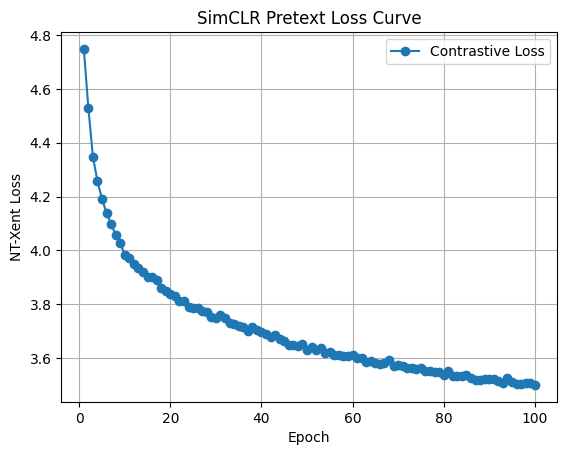

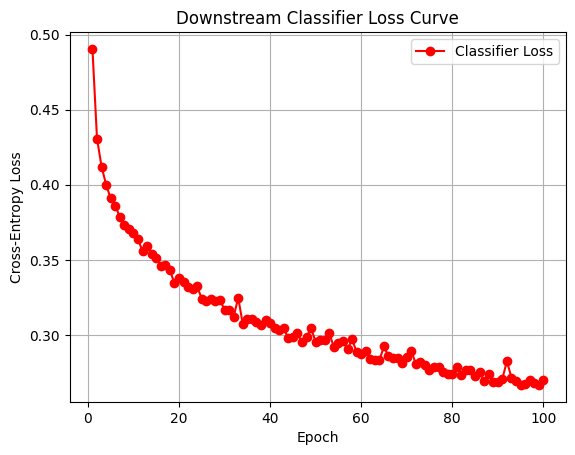

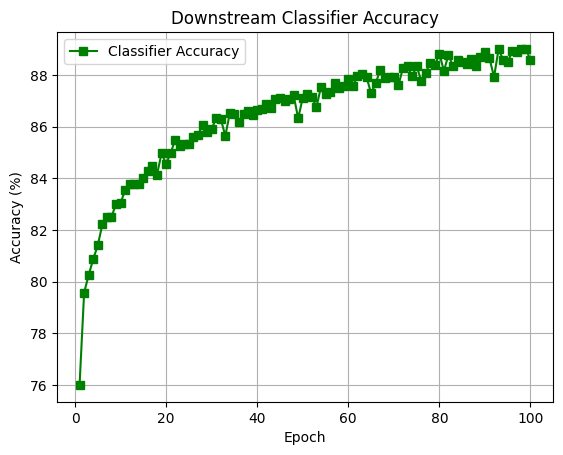

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pretext_losses) + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Pretext Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_losses) + 1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_accuracies) + 1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [29]:
from sklearn.metrics import classification_report, accuracy_score

all_preds, all_labels = [], []
classifier.eval()
model.encoder.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        features = model.encoder(imgs)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

class_names = ['Non-Cancer', 'Cancer']
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Test Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))

              precision    recall  f1-score   support

  Non-Cancer       0.83      0.89      0.86       983
      Cancer       0.88      0.82      0.85      1018

    accuracy                           0.85      2001
   macro avg       0.86      0.85      0.85      2001
weighted avg       0.86      0.85      0.85      2001

Test Accuracy: 85.41%
